In [1]:
import numpy as np
from numba import cuda
from PIL import Image
import copy
import time


@cuda.jit
def oil_painting_algo_cuda(img_from, img_to,
                           intensity_count, average_r, average_g, average_b,
                           num_bins, kernel_size):
    # http://supercomputingblog.com/graphics/oil-painting-algorithm/
    i, j = cuda.grid(2)
    if i >= img_from.shape[0] or j >= img_from.shape[1]:
        return

    top = max(i - kernel_size, 0)
    bot = min(i + kernel_size, img_from.shape[0])
    left = max(j - kernel_size, 0)
    right = min(j + kernel_size, img_from.shape[1])

    for x in range(top, bot):
        for y in range(left, right):
            cur_r = img_from[x, y, 2]
            cur_g = img_from[x, y, 1]
            cur_b = img_from[x, y, 0]
            cur_intensity = int(float(cur_r + cur_g + cur_b) / 3. * num_bins / 255.)
            intensity_count[i, j, cur_intensity] += 1
            average_r[i, j, cur_intensity] += cur_r
            average_g[i, j, cur_intensity] += cur_g
            average_b[i, j, cur_intensity] += cur_b

    cur_max = 0
    max_index = 0
    for curIntensity in range(num_bins + 1):
        if intensity_count[i, j, curIntensity] > cur_max:
            cur_max = intensity_count[i, j, curIntensity]
            max_index = curIntensity

    img_to[i, j, 2] = average_r[i, j, max_index] / cur_max
    img_to[i, j, 1] = average_g[i, j, max_index] / cur_max
    img_to[i, j, 0] = average_b[i, j, max_index] / cur_max


def oil_painting_algo_launch(img: np.ndarray, num_bins=20, kernel_size=5) -> np.ndarray:
    img_from = img.astype(float)
    img_to = copy.deepcopy(img_from)
    rows, cols, channels = img_from.shape
    intensity_count = np.zeros([rows, cols, num_bins], dtype=int)
    average_r = np.zeros([rows, cols, num_bins], dtype=float)
    average_g = np.zeros([rows, cols, num_bins], dtype=float)
    average_b = np.zeros([rows, cols, num_bins], dtype=float)

    d_img_from = cuda.to_device(img_from)
    d_img_to = cuda.to_device(img_to)
    d_intensity_count = cuda.to_device(intensity_count)
    d_average_r = cuda.to_device(average_r)
    d_average_g = cuda.to_device(average_g)
    d_average_b = cuda.to_device(average_b)
    block_size = (16, 16)
    grid_size = (int((rows + 16 - 1) / 16), int((cols + 16 - 1) / 16))
    oil_painting_algo_cuda[grid_size, block_size](d_img_from, d_img_to,
                                                  d_intensity_count, d_average_r, d_average_g, d_average_b,
                                                  num_bins, kernel_size)
    img_to = d_img_to.copy_to_host().astype(np.uint8)
    return img_to


if __name__ == '__main__':
    img_path = "./pexels-eberhard-grossgasteiger-1612357.jpg"
    img = Image.open(img_path)
    img = img.resize([int(img.size[0] / 2), int(img.size[1] / 2)])
    img_np = np.array(img)
    print("img_np.shape:", img_np.shape)
    start_time = time.perf_counter()
    img_oil_np = oil_painting_algo_launch(img_np)
    end_time = time.perf_counter()
    img_oil = Image.fromarray(img_oil_np, mode="RGB")
    print(f"finish infer in {end_time - start_time} seconds")


img_np.shape: (1216, 1824, 3)
finish infer in 1.5205462489998354 seconds


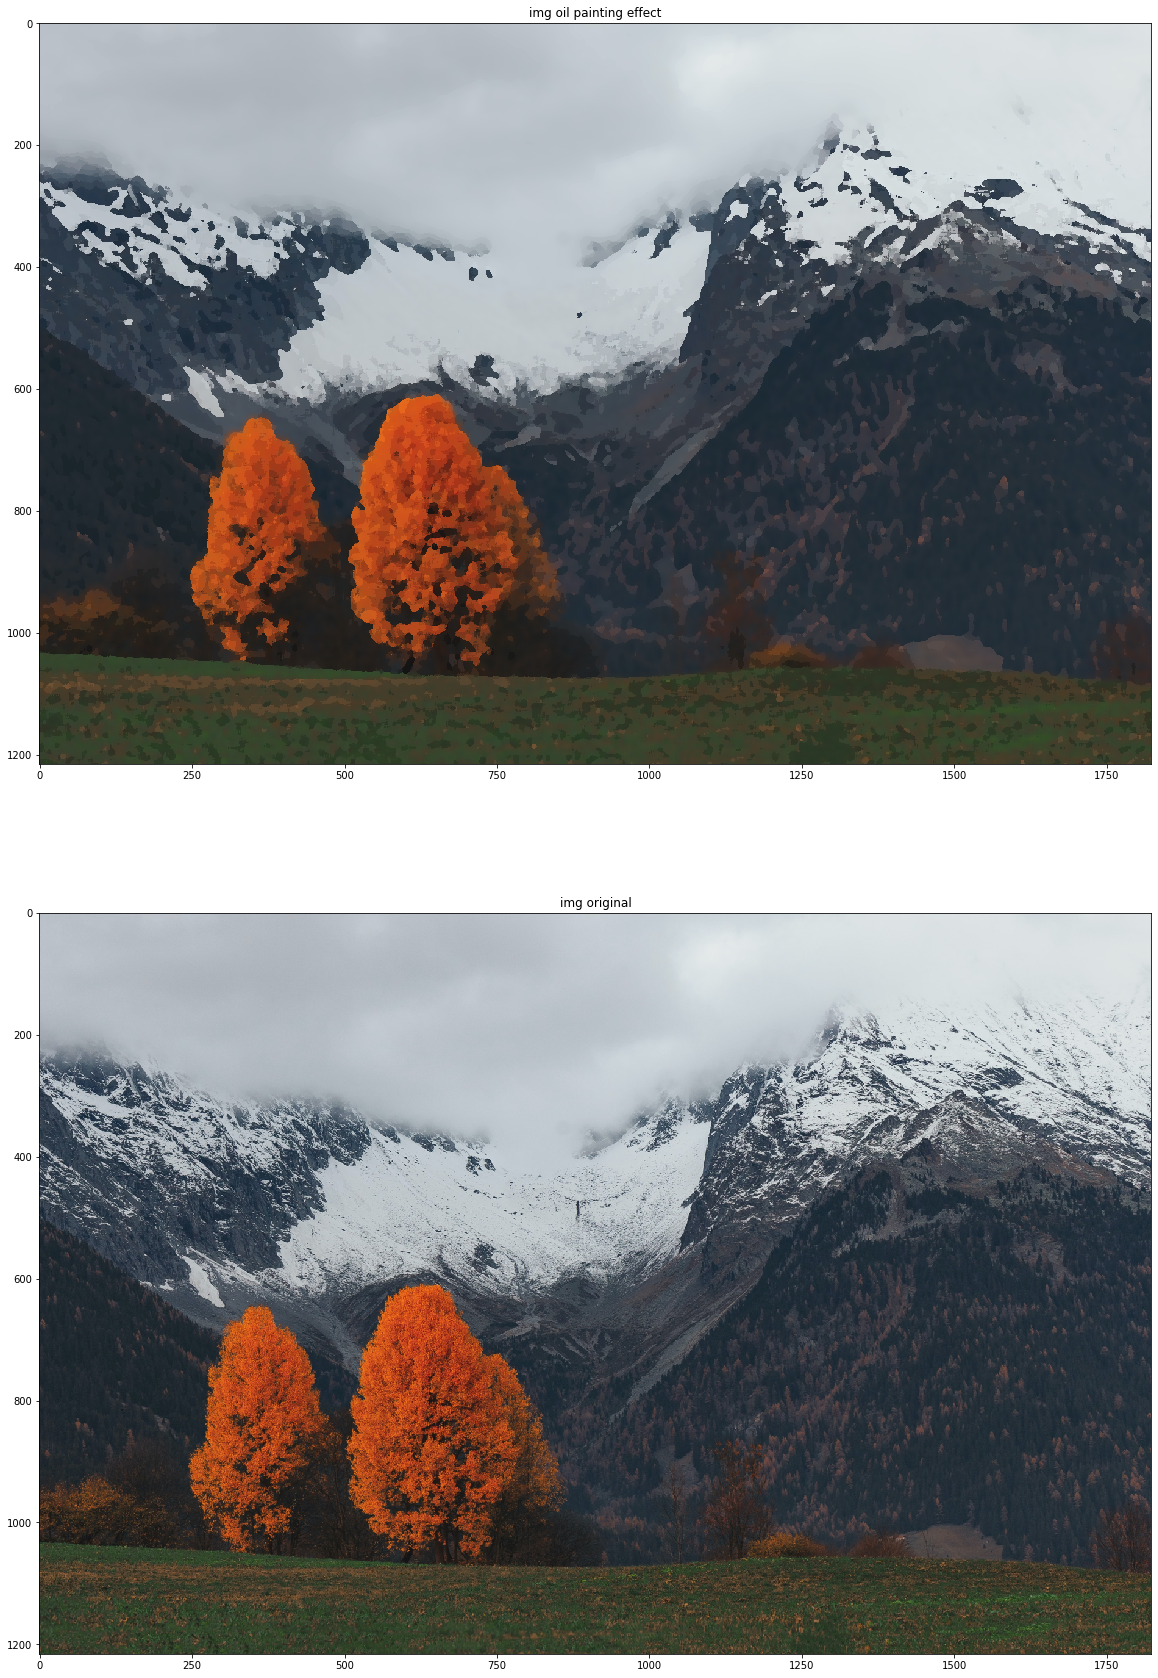

In [2]:
import matplotlib.pyplot as plt
fig1 = plt.figure(figsize = (30,30)) # create a figure with the default size

ax1 = fig1.add_subplot(2,1,1)
ax1.imshow(img_oil, interpolation='none')
ax1.set_title('img oil painting effect')

ax2 = fig1.add_subplot(2,1,2)
ax2.imshow(img, interpolation='none')
ax2.set_title('img original')

plt.show()

In [3]:
!nvidia-smi

Fri Mar 18 16:21:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.52       Driver Version: 511.79       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| N/A   49C    P0    22W /  N/A |    737MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------